# Load Data

In [1]:
import pandas as pd
import numpy as np

# Train
x_train_df = pd.read_csv('data_homiris/X_train_int_sample.csv', delimiter=';', dtype=float)
X_train = x_train_df.values

y_train_df = pd.read_csv('data_homiris/y_train_int_sample.csv', delimiter=';', dtype=float)
y_train = y_train_df.values.ravel()

# Test29
x_test_df = pd.read_csv('data_homiris/X_test_int_sample.csv', delimiter=';', dtype=float)
X_test = x_test_df.values

y_test_df = pd.read_csv('data_homiris/y_test_int_sample.csv', delimiter=';', dtype=float)
y_test = y_test_df.values.ravel()


print(X_train.shape, X_test.shape)
print()

# Count the number of samples in y_test=0 and y_test=1 before sampling
count_y_test_0 = np.sum(y_test == 0)
count_y_test_1 = np.sum(y_test == 1)
print("Counts - y_test=0:", count_y_test_0, "y_test=1:", count_y_test_1)


(10000, 20) (10000, 20)

Counts - y_test=0: 5000 y_test=1: 5000


# Scale Data

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.2, 2.8))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create Heisenberg Circuit

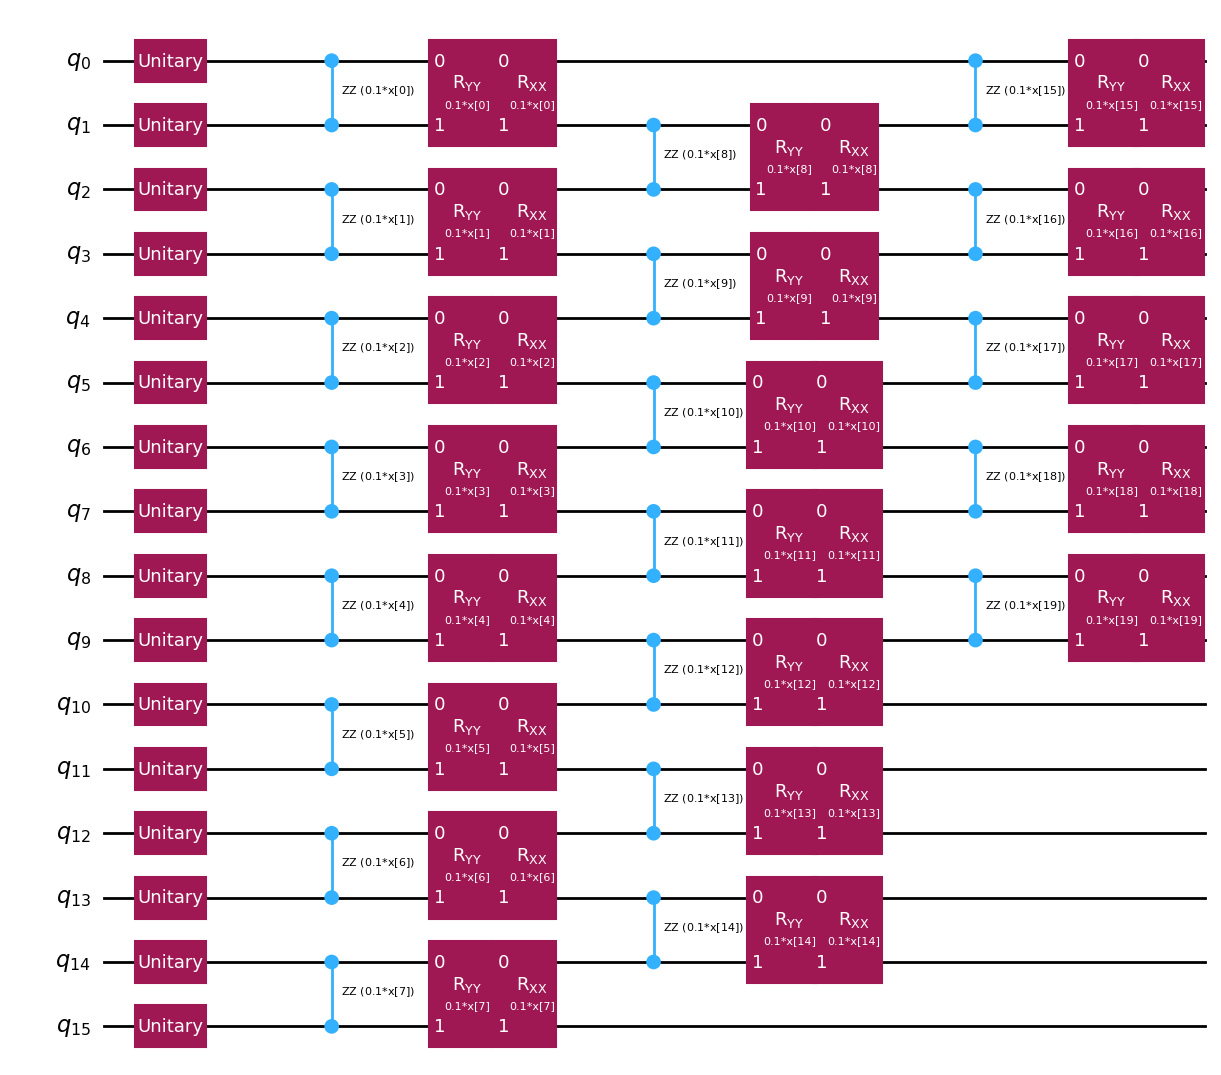

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

# Function to construct a parametric evolution gate for the Heisenberg model
def construct_parametric_evolution_gate_heisenberg(nbqbits, reps, n_features, random_seed, alpha):
    """
    Construct a parametric quantum circuit for the Heisenberg model.
    
    Args:
        nbqbits (int): Number of qubits.
        reps (int): Number of repetitions for the evolution steps.
        n_features (int): Number of features (evolution parameters).
    
    Returns:
        QuantumCircuit: The constructed parametric quantum circuit.
        ParameterVector: The feature parameters (x_vec).
        ParameterVector: The rotational parameters (the_vec).
        Parameter: The alpha parameter for the circuit.
    """
    assert nbqbits > 1, 'There should be at least 2 qubits in the circuit'

    # Define the alpha parameter and the parameter vectors for the circuit
    #alpha = Parameter(r'$\alpha$')
    x_vec = ParameterVector('x', n_features)

    # Create a quantum circuit with the given number of qubits
    qr = QuantumRegister(nbqbits, name='q')
    qc = QuantumCircuit(qr)

    # Add hadamards
    # for i in range(nbqbits):
    #     qc.h(i)

    # Initialize random number generatora
    rng = np.random.default_rng(random_seed)
    
    # Append initial random unitary gates
    for i in range(nbqbits):
        random_unitary_gate = UnitaryGate(random_unitary(2, rng))
        qc.append(random_unitary_gate, [i])
        
    #psi_0 = Statevector(qc).data
    
    # Define the even-odd pattern for the Heisenberg evolution
    evens = [i for i in range(0, nbqbits - 1) if i % 2 == 0]
    odds = [i for i in range(1, nbqbits - 1) if i % 2 != 0]
    sequence = (evens + odds) * int(np.ceil(n_features / (nbqbits - 1)))

    # Apply the Heisenberg evolution for the number of repetitions
    for t_s in range(reps):
        con = 0
        for i in range(n_features):
            j = sequence[i]
            the_j = alpha * x_vec[con]

            # Apply the Heisenberg interaction gates
            qc.rzz(the_j, qr[j], qr[j + 1])
            qc.ryy(the_j, qr[j], qr[j + 1])
            qc.rxx(the_j, qr[j], qr[j + 1])
            
            con += 1

    return qc, x_vec#, alpha#, psi_0

nbqbits = 16
n_features = 20
reps = 1
seed = 42
alpha = 0.1

qc, x_vec = construct_parametric_evolution_gate_heisenberg(nbqbits, reps, n_features, seed, alpha)

# print(psi_0)

qc.draw('mpl')

# Construct Sensibility Matrix

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
import ray
import pandas as pd
import numpy as np

from quantum_feature_generation import (
    get_optimal_parameters, generate_pauli_strings, initialize_ray, get_projected_quantum_features
)

class ProjectedQuantumFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, partial_bound_qc, rdm_type='one', batch_size=None, n_jobs=None, num_cpus=None):
        """
        Added `num_cpus` to control Ray cluster CPU allocation dynamically.
        """
        self.partial_bound_qc = partial_bound_qc
        self.rdm_type = rdm_type
        self.batch_size = batch_size
        self.n_jobs = n_jobs
        self.num_cpus = num_cpus
        self.pauli_strings = None
        self.nbqbits = None

    def fit(self, X, y=None):
        # Determine number of qubits from the circuit
        self.nbqbits = self.partial_bound_qc.num_qubits

        # Determine and set optimal parameters if not provided
        params = get_optimal_parameters(self.nbqbits)
        if self.batch_size is None:
            self.batch_size = params["batch_size"]
        if self.n_jobs is None:
            self.n_jobs = params["n_jobs"]
        if self.num_cpus is None:
            self.num_cpus = params["num_cpus"]
        
        # # Initialize Ray with the given number of CPUs
        # ray.shutdown()  # Shutdown any existing Ray cluster
        # initialize_ray(self.num_cpus)
        
        # Generate Pauli strings for the given qubit size and rdm_type
        self.pauli_strings = generate_pauli_strings(self.nbqbits, rdm_type=self.rdm_type)
        
        return self
    
    def transform(self, X):
        """
        Transform the input data into quantum features by computing the expectation values
        of the provided circuit with the specified Pauli strings.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples to transform.
        
        Returns
        -------
        pd.DataFrame
            A DataFrame containing the quantum features (expectation values).
        """
        # Ensure X is a NumPy array
        X = np.array(X)
        
        # Generate quantum features
        QX = get_projected_quantum_features(
            X_balanced=X,
            transpiled_circuit=self.partial_bound_qc,
            pauli_strings=self.pauli_strings,
            batch_size=self.batch_size,
            n_jobs=self.n_jobs
        )
        
        return QX

# Sensitivity Matrix


$$S_{ij}=\frac{1}{M}\sum_{k=0}^{M-1}\left|\frac{\partial f_j}{\partial \theta_i}\left(\vec{\theta}_k\right)\right|$$

M = Size of the dataset

$f_j(\vec{\theta}) = \langle \psi(\vec{\theta}) | \hat{O}_j | \psi(\vec{\theta}) \rangle = \langle \psi |\mathcal{G}^\dagger\left(\theta_i\right) \hat{Q_j}\mathcal{G}\left(\theta_i\right)|\psi \rangle$

$\mathcal{G}\left(\theta\right)=e^{-i\frac{\alpha \theta}{2}\left(XX+YY+ZZ\right)}$

In [36]:
import os
import time
import numpy as np
import pandas as pd
import pickle

def compute_sensitivity_matrix(X, pqfm, alpha, output_dir="shifted_data"):
    """
    Compute the sensitivity matrix via the parameter-shift rule, saving
    QX_plus and QX_minus for each feature as pickle files in a structured folder hierarchy.
    
    For each original feature θ_i (i.e., each column of X):
      - Create two shifted datasets: X_plus, X_minus, with ± π/(4*alpha) added to θ_i.
      - Compute the quantum features QX_plus and QX_minus via pqfm.transform.
      - Save QX_plus and QX_minus as pickle files in output_dir/theta_i.
      - Estimate the derivative: dQX_i = alpha * (QX_plus - QX_minus).
      - Average the absolute derivative over samples to obtain the sensitivity for feature i.
    
    Parameters:
    -----------
      X : np.ndarray
          Dataset of shape (n_samples, n_features) (e.g. X_train_scaled).
      pqfm : ProjectedQuantumFeatures
          Fitted transformer (an instance of ProjectedQuantumFeatures).
      alpha : float
          The alpha parameter used in your circuit.
      output_dir : str
          Top-level directory where QX_plus and QX_minus will be saved.
    
    Returns:
    --------
      S_df : pd.DataFrame
          A DataFrame of shape (n_features, n_quantum_features) where each row corresponds
          to an original feature (θ_i) and each column corresponds to a quantum observable
          (named by its corresponding Pauli string).
    """
    start_total = time.time()
    print("Starting sensitivity matrix computation...")
    
    # Create the output directory if it doesn't exist.
    os.makedirs(output_dir, exist_ok=True)
    
    n_samples, n_features = X.shape
    n_quantum_features = len(pqfm.pauli_strings)
    
    print(f"Dataset contains {n_samples} samples and {n_features} features.")
    print(f"Found {n_quantum_features} quantum observables (pauli_strings).")
    
    # Define the shift as π/(4*alpha)
    shift = np.pi / (4 * alpha)
    print(f"Using shift value: {shift:.4f} (π/(4*alpha)).")
    
    # Initialize the sensitivity matrix S.
    S = np.zeros((n_features, n_quantum_features))
    
    # Use the actual Pauli string names for the column labels.
    pauli_columns = [str(ps) for ps in pqfm.pauli_strings]
    
    # Loop over each original feature θ_i.
    for i in range(n_features):
        print(f"\nProcessing feature theta_{i}...")
        start_feature = time.time()
        
        # Create copies of X for shifting the i-th feature.
        X_plus = X.copy()
        X_minus = X.copy()
        
        # Shift the i-th column.
        X_plus[:, i] += shift
        X_minus[:, i] -= shift
        
        # Compute the quantum features for the shifted datasets.
        print("  Computing QX_plus ...")
        start_qx_plus = time.time()
        QX_plus = pqfm.transform(X_plus)
        elapsed_qx_plus = time.time() - start_qx_plus
        print(f"  QX_plus computed in {elapsed_qx_plus:.2f} seconds.")
        
        print("  Computing QX_minus ...")
        start_qx_minus = time.time()
        QX_minus = pqfm.transform(X_minus)
        elapsed_qx_minus = time.time() - start_qx_minus
        print(f"  QX_minus computed in {elapsed_qx_minus:.2f} seconds.")
        
        # Save QX_plus and QX_minus as pickle files in a subdirectory for this feature.
        feature_dir = os.path.join(output_dir, f"theta_{i}")
        os.makedirs(feature_dir, exist_ok=True)
        
        QX_plus_file = os.path.join(feature_dir, "QX_plus.pkl")
        QX_minus_file = os.path.join(feature_dir, "QX_minus.pkl")
        with open(QX_plus_file, "wb") as f:
            pickle.dump(QX_plus, f)
        with open(QX_minus_file, "wb") as f:
            pickle.dump(QX_minus, f)
        
        # Estimate the derivative using the parameter-shift rule:
        # dQX_i = alpha * (QX_plus - QX_minus).
        dQX = alpha * (QX_plus - QX_minus)
        
        # Average the absolute derivative over samples to obtain sensitivity for feature i.
        sensitivity_i = np.mean(np.abs(dQX), axis=0)
        S[i, :] = sensitivity_i
        
        elapsed_feature = time.time() - start_feature
        print(f"Feature theta_{i} processed in {elapsed_feature:.2f} seconds.")
    
    total_time = time.time() - start_total
    print(f"\nSensitivity matrix computed in {total_time:.2f} seconds.")
    
    # Convert S into a DataFrame with informative row/column labels.
    S_df = pd.DataFrame(S,
                        index=[f"theta_{i}" for i in range(n_features)],
                        columns=pauli_columns)
    
    return S_df


In [37]:
pqfm = ProjectedQuantumFeatures(partial_bound_qc=qc)

pqfm.fit(X_train_scaled)

print(len(pqfm.pauli_strings))

48


In [38]:
# Example usage:
alpha = 0.1  # Your alpha value used in the circuit

# Make sure your transformer is fitted:
# e.g., pqfm.fit(X_train_scaled)
print("Pauli strings (observables) used:", pqfm.pauli_strings)
print(f"Number of quantum observables: {len(pqfm.pauli_strings)}\n")

# Compute the sensitivity matrix
S_df = compute_sensitivity_matrix(X_train_scaled, pqfm, alpha)

# Display the resulting sensitivity matrix
print("\nSensitivity Matrix:")
print(S_df)


Pauli strings (observables) used: ['IIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIYI', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIYII', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIXIII', 'IIIIIIIIIIIIYIII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIXIIII', 'IIIIIIIIIIIYIIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIXIIIII', 'IIIIIIIIIIYIIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIXIIIIII', 'IIIIIIIIIYIIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIXIIIIIII', 'IIIIIIIIYIIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIXIIIIIIII', 'IIIIIIIYIIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIXIIIIIIIII', 'IIIIIIYIIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIXIIIIIIIIII', 'IIIIIYIIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIXIIIIIIIIIII', 'IIIIYIIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIXIIIIIIIIIIII', 'IIIYIIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIXIIIIIIIIIIIII', 'IIYIIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IXIIIIIIIIIIIIII', 'IYIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'XIIIIIIIIIIIIIII', 'YIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII']
Numbe

# Save Sensibility Matrix

In [39]:
import pickle

with open("sensitivity_matrix.pkl", "wb") as f:
    pickle.dump(S_df, f)


# Visualize Matrix

In [40]:

QX_train_df = pd.read_pickle('data_homiris_quantum/QX_train_int_sample.pkl')

print(QX_train_df.head())

   IIIIIIIIIIIIIIIX  IIIIIIIIIIIIIIIY  IIIIIIIIIIIIIIIZ  IIIIIIIIIIIIIIXI  \
0         -0.616605          0.123558          0.629610          0.130966   
1         -0.610697          0.137628          0.637487          0.071472   
2         -0.454690          0.246903          0.319110         -0.073101   
3         -0.603495          0.141986          0.616244          0.088804   
4         -0.632998          0.105483          0.674831          0.113647   

   IIIIIIIIIIIIIIYI  IIIIIIIIIIIIIIZI  IIIIIIIIIIIIIXII  IIIIIIIIIIIIIYII  \
0         -0.131208         -0.869759         -0.346136         -0.178894   
1         -0.090851         -0.885836         -0.278898         -0.372822   
2         -0.213413         -0.564970         -0.315897         -0.232238   
3         -0.117145         -0.861392         -0.321221         -0.224712   
4         -0.075346         -0.921167         -0.295988         -0.357422   

   IIIIIIIIIIIIIZII  IIIIIIIIIIIIXIII  ...  IIIZIIIIIIIIIIII  \
0         

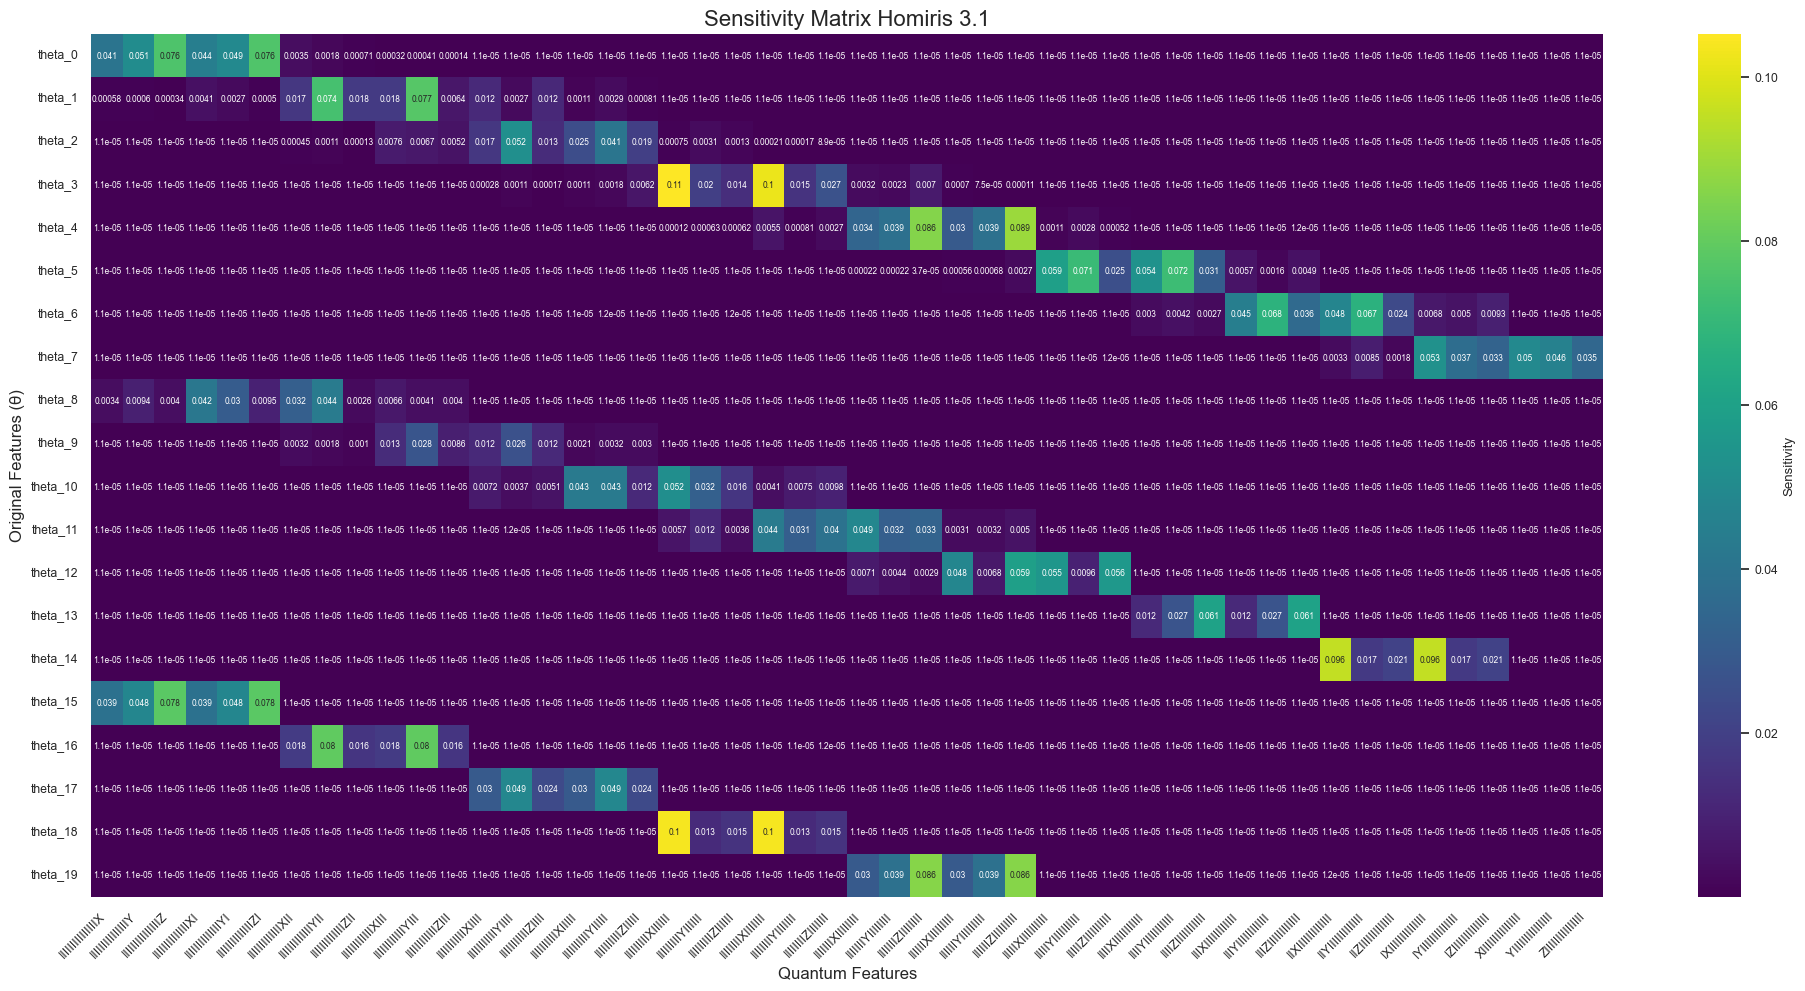

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sensitivity_heatmap(S_df, title="Sensitivity Matrix", 
                             figsize=(20, 10), font_scale=0.8, 
                             annot=True, annot_fontsize=6):
    """
    Plot a heatmap of the sensitivity matrix with adjustable figure size, 
    font scale, and annotation parameters.
    
    Parameters:
    -----------
    S_df : pd.DataFrame
        The sensitivity matrix (features vs. quantum observables).
    title : str
        Title of the heatmap.
    figsize : tuple
        Size of the figure (width, height).
    font_scale : float
        Scale factor for overall fonts (Seaborn's set).
    annot : bool
        Whether to annotate the heatmap cells with numeric values.
    annot_fontsize : int
        Font size for annotations.
    """
    # Set up figure and font scaling
    plt.figure(figsize=figsize)
    sns.set(font_scale=font_scale)

    # Plot the heatmap
    ax = sns.heatmap(
        S_df, 
        annot=annot, 
        cmap="viridis", 
        fmt=".2g",  # 2 significant digits
        cbar_kws={'label': 'Sensitivity'},
        annot_kws={"size": annot_fontsize}
    )

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Set labels and title
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Quantum Features", fontsize=12)
    ax.set_ylabel("Original Features (θ)", fontsize=12)

    # Ensure everything fits
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sensitivity_heatmap(S_df, title="Sensitivity Matrix Homiris 3.1")


# Load Quantum Feature Importance

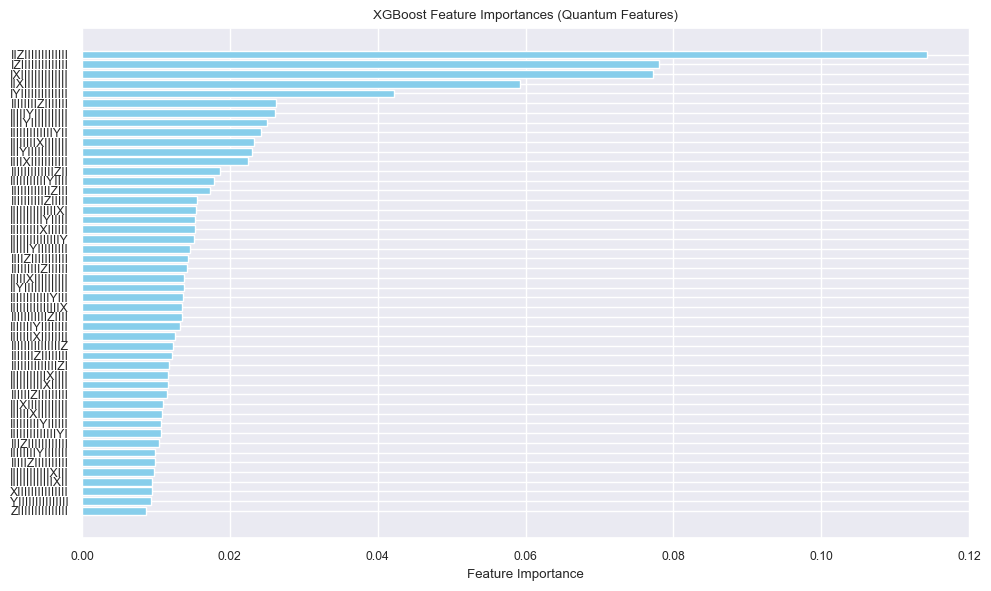

In [44]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

######################################
# PART 1: Load Quantum Model & Importances
######################################

# Parameters for model file and data file (quantum)
res_dir = "qp_model_results"
model_name = "qp_model"
backend_name = "quantum"
model_path = f"{res_dir}/{model_name}_{backend_name}.pkl"
quantum_data_file = "data_homiris_quantum/QX_train_int_sample.pkl"  # Quantum training data file

# Load the saved best quantum model (a pipeline)
with open(model_path, "rb") as f:
    best_model = pickle.load(f)

# Extract the XGBClassifier step from the pipeline
xgb_model = best_model.named_steps["xgb"]

# Get the quantum feature importances from the XGBoost model
quantum_importances = xgb_model.feature_importances_

# Load the quantum dataset to obtain quantum feature names.
df_quantum = pd.read_pickle(quantum_data_file)
if df_quantum.columns is None or len(df_quantum.columns) == 0:
    quantum_feature_names = [f"feature_{i}" for i in range(df_quantum.shape[1])]
else:
    quantum_feature_names = df_quantum.columns.tolist()

# Create a DataFrame for plotting the quantum feature importances
importance_df_quantum = pd.DataFrame({
    "feature": quantum_feature_names,
    "importance": quantum_importances
}).sort_values(by="importance", ascending=False)

# Plot horizontal bar chart of quantum feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_quantum["feature"], importance_df_quantum["importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances (Quantum Features)")
plt.gca().invert_yaxis()  # Most important features on top
plt.tight_layout()
plt.show()


# Backpropagate feature importances

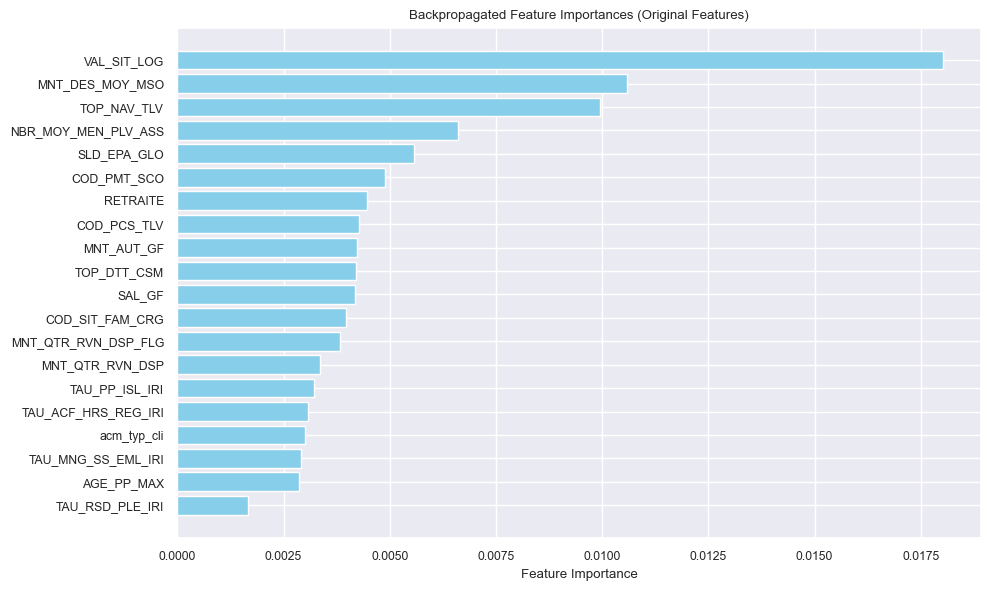

In [45]:

######################################
# PART 2: Backpropagate Importances to Original Features
######################################

# Assume you have already computed the sensitivity matrix S_df
# S_df should be a DataFrame of shape (n_original_features, n_quantum_features)
# with column names matching the quantum feature names (Pauli strings)
#
# For example, if you previously saved it as a pickle file:
# with open("sensitivity_matrix.pkl", "rb") as f:
#     S_df = pickle.load(f)

# Backpropagation via simple matrix multiplication:
# For each original feature, its importance is the weighted sum over quantum features.
backprop_importances = S_df.dot(quantum_importances)
# backprop_importances is a pandas Series (or numpy array) of shape (n_original_features,)

######################################
# PART 3: Plot Backpropagated Original Feature Importances
######################################

# Load the original dataset to get the original feature names
orig_data_file = "data_homiris/X_train_int_sample.csv"  # Original training data file
df_orig = pd.read_csv(orig_data_file, delimiter=';', dtype=float)
original_feature_names = df_orig.columns.tolist()

# Create a DataFrame for original feature importances
importance_df_orig = pd.DataFrame({
    "feature": original_feature_names,
    "importance": backprop_importances  # vector of backpropagated importances
}).sort_values(by="importance", ascending=False)

# Plot horizontal bar chart for the original feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_orig["feature"], importance_df_orig["importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Backpropagated Feature Importances (Original Features)")
plt.gca().invert_yaxis()  # Most important features on top
plt.tight_layout()
plt.show()


# Compare Classical and Backpropagated feature importances

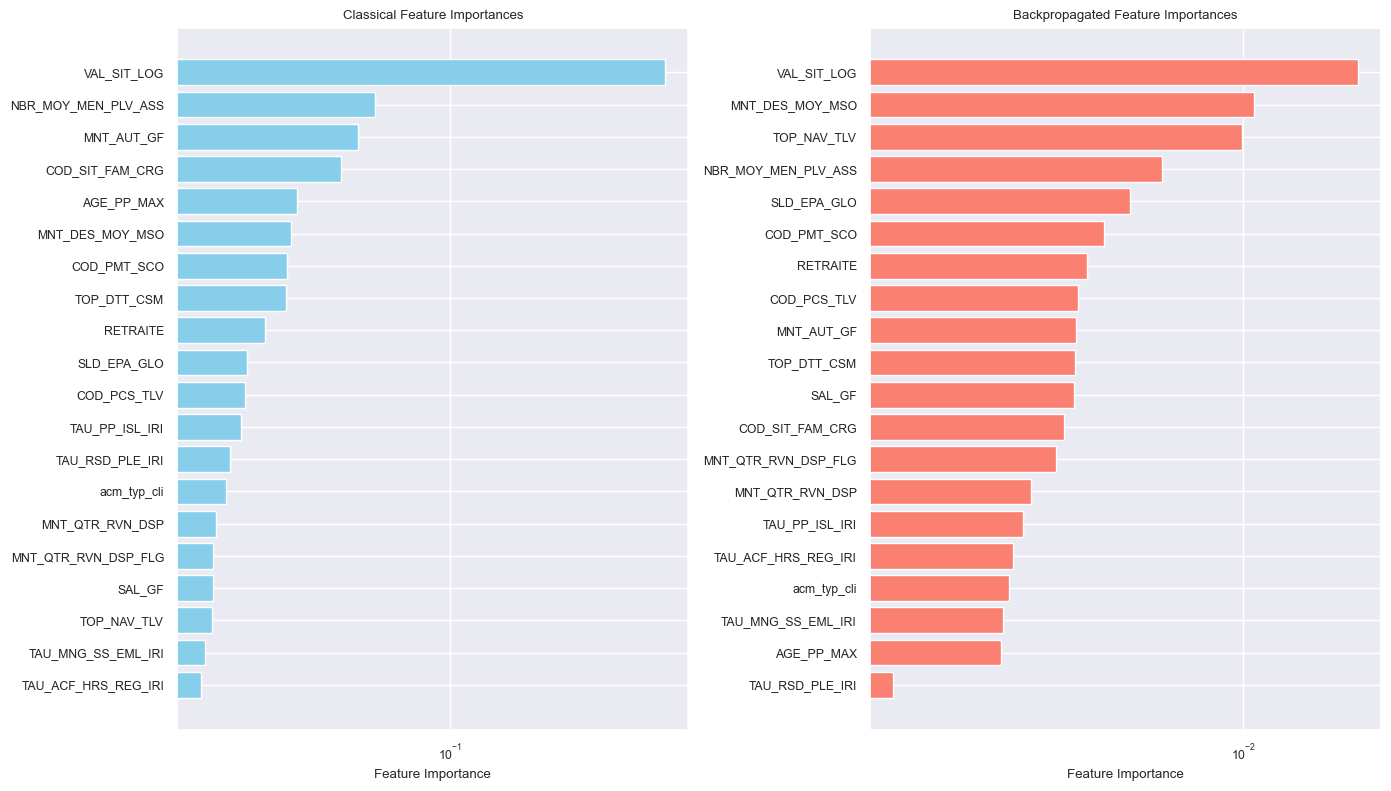

In [47]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

######################################
# PART 1: Load Classical Model & Importances
######################################

# Parameters for the classical model and data file
res_dir = "cp_model_results"
model_name = "cp_model"
backend_name = "classical"
model_path = f"{res_dir}/{model_name}_{backend_name}.pkl"
data_file = "data_homiris/X_train_int_sample.csv"  # Original training data file

# Load the saved best classical model (a pipeline)
with open(model_path, "rb") as f:
    best_model_classical = pickle.load(f)

# Extract the XGBClassifier step from the pipeline
xgb_model_classical = best_model_classical.named_steps["xgb"]

# Get the feature importances from the XGBoost model (classical)
classical_importances = xgb_model_classical.feature_importances_

# Load the original dataset to obtain feature names
df_orig = pd.read_csv(data_file, delimiter=';', dtype=float)
original_feature_names = df_orig.columns.tolist()

# Create a DataFrame for the classical feature importances
classical_df = pd.DataFrame({
    "feature": original_feature_names,
    "classical_importance": classical_importances
})

######################################
# PART 2: Combine with Backpropagated Importances
######################################

# Assume you have already computed the backpropagated importances (e.g., from your quantum pipeline)
# For example: backprop_importances = S_df.dot(quantum_importances)
# backprop_importances should be a NumPy array of shape (n_features,)
quantum_bp_df = pd.DataFrame({
    "feature": original_feature_names,
    "quantum_bp_importance": backprop_importances
})

# Merge the two DataFrames on the feature name
comparison_df = pd.merge(classical_df, quantum_bp_df, on="feature")

# Create sorted DataFrames for each subplot:
# Sort descending so that the highest values will appear at the top when the y-axis is inverted.
classical_sorted_df = comparison_df.sort_values(by="classical_importance", ascending=False)
quantum_sorted_df = comparison_df.sort_values(by="quantum_bp_importance", ascending=False)

######################################
# PART 3: Plot Two Side-by-Side Subplots
######################################

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# --- Left subplot: Classical Feature Importances ---
ax = axes[0]
indices = np.arange(len(classical_sorted_df))
ax.barh(indices, classical_sorted_df["classical_importance"], color="skyblue")
ax.set_yticks(indices)
ax.set_yticklabels(classical_sorted_df["feature"])
ax.invert_yaxis()  # Invert y-axis so the highest importance is at the top
ax.set_xlabel("Feature Importance")
ax.set_title("Classical Feature Importances")
ax.set_xscale('log')

# --- Right subplot: Backpropagated (Quantum) Feature Importances ---
ax = axes[1]
indices = np.arange(len(quantum_sorted_df))
ax.barh(indices, quantum_sorted_df["quantum_bp_importance"], color="salmon")
ax.set_yticks(indices)
ax.set_yticklabels(quantum_sorted_df["feature"])
ax.invert_yaxis()  # Invert y-axis so the highest importance is at the top
ax.set_xlabel("Feature Importance")
ax.set_title("Backpropagated Feature Importances")
ax.set_xscale('log')

plt.tight_layout()
plt.show()
